# **Dokumentacja końcowa**
## **Autorzy:** Mateusz Szczęsny, Małgorzata Kubiak
### **Temat projektu:** Nienadzorowana detekcja anomalii na podstawie niepodobieństwa do sąsiadów

## **Pełna treść zadania:**
Nienadzorowana detekcja anomalii na podstawie niepodobieństwa do sąsiadów z możliwością użycia dowolnej miary niepodobieństwa. Porównanie z nienadzorowaną detekcją anomalii za pomocą algorytmów klasyfikacji jednoklasowej dostępnych w środowisku R lub Python.


## **Opis implementacji**
Tutaj jakis opis

## Uzyte bilbioteki

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import test_functions
from our_knn import KNNAnomalyDetector
from sklearn.preprocessing import StandardScaler
import plotting_functions
from sklearn.model_selection import StratifiedKFold
import numba as nb
from sklearn.metrics import precision_recall_curve, auc, f1_score

#%matplotlib ipympl

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## **Opis i wizualizacje zbiorów danych**

Do testów wybrane zostały 2 zbiory danych znalezione na stronie internetowej Outlier Detection DataSets (ODDS). Są to zbiory "thyroid" i "cardio". 

Zbiór "thyroid" (tarczyca) składa się z 3772 przykładów. Każdy przykład ma 6 ciągłych atrybutów. Klasą traktowaną jako anomalia jest nadczynność tarczycy i stanowi około 2.5% przykładów. 

Zbiór "cardio" złożony jest z danych pomiarowych czynności serca. Zbiór zawiera 1831 przykładów. Każdy przykład ma 21 atrybutów. Klasa traktowana jako anomalia to patologiczna praca serca. Anomalie stanowią około 9.6% zbioru danych. 

### Wczytywanie i wizualizacja zbioru "thyroid"

In [14]:
# load thyroid dataset
# labels are 0 1 where 1 is anomaly. Feature 1 is an integer. Other features are continuos
thyroid_data = pd.read_csv('thyroid.csv') 
thyroid_data_columns = thyroid_data.columns
thyroid_features = thyroid_data[thyroid_data_columns[:6]]
thyroid_labels = thyroid_data[thyroid_data_columns[6]]

# change labels so 1 in no anomalyand -1 is anomaly (sklearn anomaly detecion convention)
thyroid_labels[thyroid_labels == 1] = -1
thyroid_labels[thyroid_labels == 0] = 1

### Korelacja atrybutów w zbiorze danych

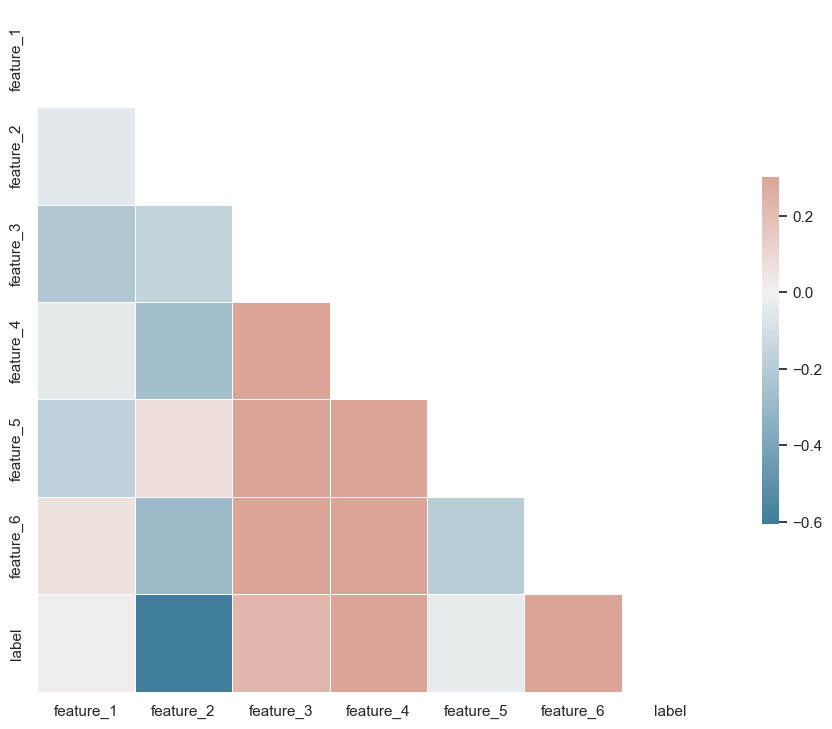

In [15]:
plotting_functions.plot_corr(thyroid_data)

Widzimy że "feautre_2" ma dość mocną korelacje z klasą. Pozatym Atrybuty mają dość niskie korelacje między sobą. 

### Wizualizacja rozkładu atrybutów zbioru "thyroid"

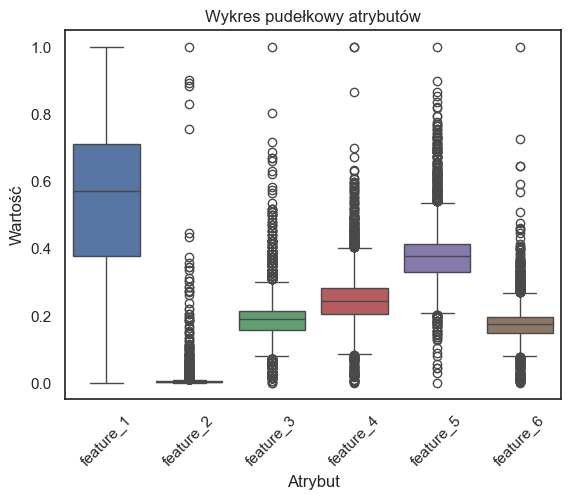

In [16]:
plotting_functions.plot_feature_dist(thyroid_features)

Na wykresie widzimy że poza atrybutem nr. 1 (feature_1) atrybuty posiadają sporo wartości które można uznać za odstające, czyli wychodzące o ponad 1.5 odległości miedzy pierwszym a trzecim kwartylem od bliższego im brzegu pudełka. 

### Wizualizacja relacji 3 głównych komponetnów zbioru "thyroid"

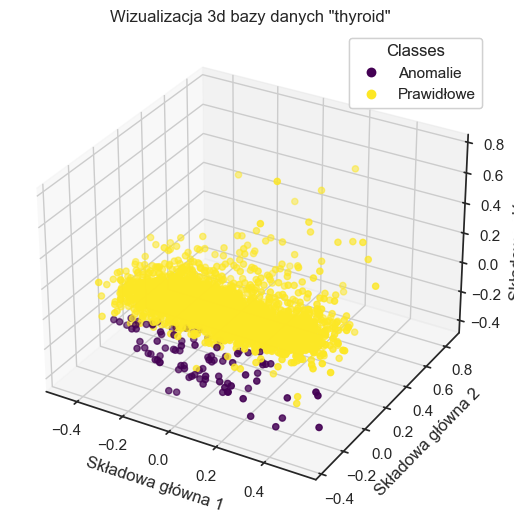

In [17]:
# 3D PCA thyroid dataset visualisation
plotting_functions.plot_pca_3d(thyroid_features, thyroid_labels, "Wizualizacja 3d bazy danych \"thyroid\"")

Powyższa wizualizacja przedstawia zbiór danych po rozkładzie na 3 główne składowe. Przy takim rozładzie widać że klasa anomalii znajduje się niedaleko ale jednak poza głównym skupiskiem punktów. 

## Wczytywanie i wizualizacja zbioru "shuttle"

In [18]:
# shuttle dataset loading. The dataset cointains 9 features and 7 classes. Class '1' makes up 80% of the dataset. For ourlier detection class '4'is discarted and the other classes are combined. 
shuttle_colnames=['feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5', 'feature_6', 'feature_7', 'feature_8', 'feature_9', 'label']
shuttle_data = pd.read_csv('shuttle.tst', sep=' ', header=None, names=shuttle_colnames)

shuttle_data = shuttle_data[shuttle_data['label'] != 4] # remove class '4'

shuttle_data = shuttle_data.iloc[:3000] # shrink dataset for test purposes

shuttle_features = shuttle_data[shuttle_colnames[:9]]
shuttle_labels = shuttle_data[shuttle_colnames[9]]

shuttle_labels[shuttle_labels == 1] = 1
shuttle_labels[(shuttle_labels == 2) | (shuttle_labels == 3) | (shuttle_labels == 5) | (shuttle_labels == 6) | (shuttle_labels == 7)] = -1


In [19]:
# add standard scaler because of large feature value range differences
shuttle_scaler = StandardScaler()
shuttle_feature_columns = shuttle_features.columns
shuttle_features = pd.DataFrame(shuttle_scaler.fit_transform(shuttle_features), columns=shuttle_feature_columns)

### Wizualizacja korelacji atrybutów zbioru "shuttle"

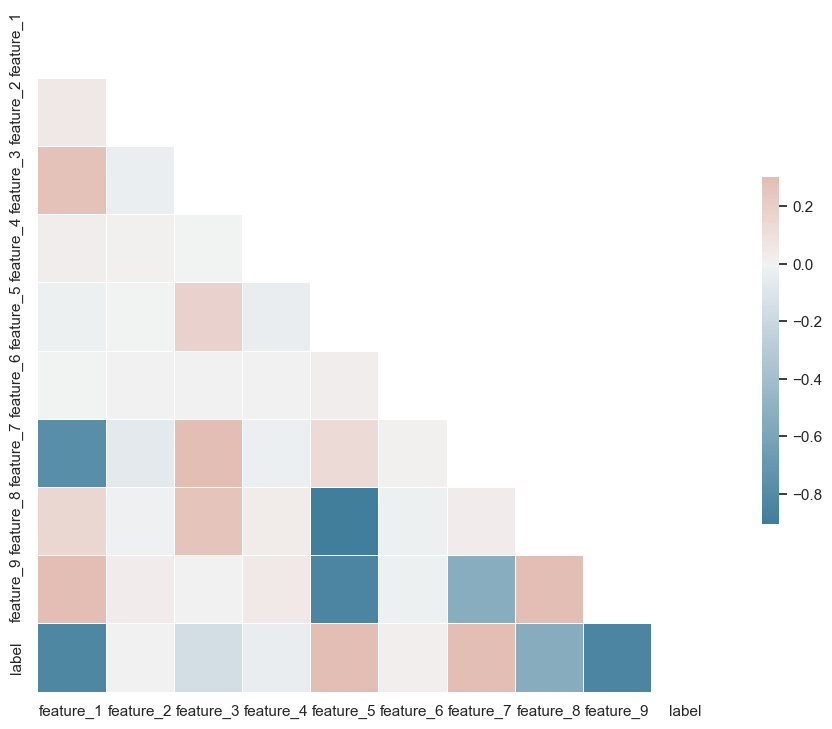

In [20]:
plotting_functions.plot_corr(shuttle_data)

W zbiorze "shuttle" widzimy ujemną korelacje między feature_1 i fature_9 a klasą przykładu. Widzimy też ujemne korelacje między atrybutami o numerach 1 i 7, 5 i 8 oraz 5 i 9. Reszta korelacji jest dużo mniejsza. 

### Wizyalizacja rozkładu wartości atrybutów zbioru "shuttle"

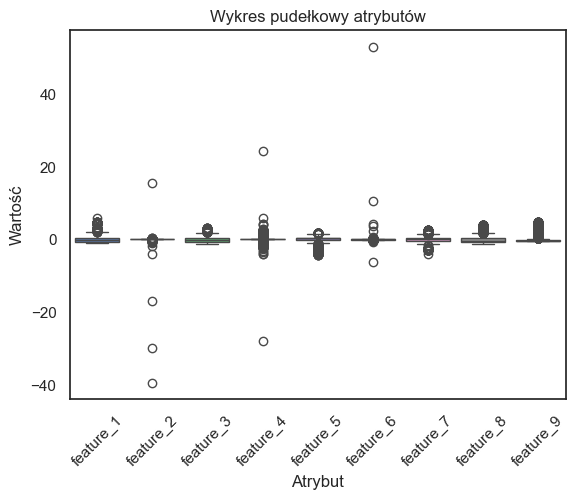

In [21]:
plotting_functions.plot_feature_dist(shuttle_features)

Jeszcze bardziej niż w przypadku zbioru "thyroid", na zbiorze "shuttle" widzimy że wszystkie atrybuty maja bardzo mocno odstające od więszkości przykłady pod względem wartości atrybutów. 

### Wizualizcja 3d głównych składowych zbioru "shuttle"

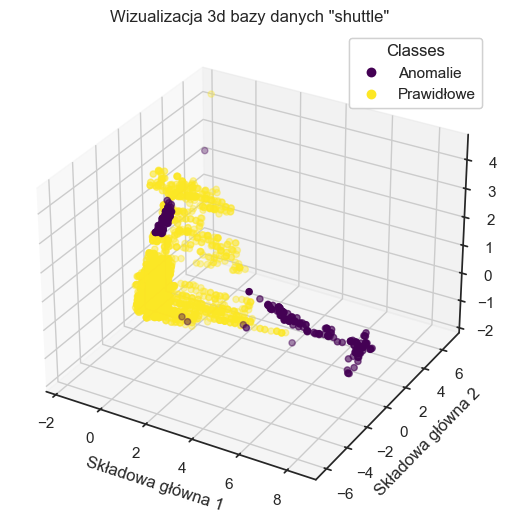

In [22]:
# 3D PCA thyroid dataset visualization

# remove some extreme values for visualization (this is used insead of crop/zoom)
PCA_shuttle_features = shuttle_features[shuttle_features < 20].dropna()
PCA_shuttle_labels = shuttle_labels.iloc[PCA_shuttle_features.index]

plotting_functions.plot_pca_3d(PCA_shuttle_features, PCA_shuttle_labels, "Wizualizacja 3d bazy danych \"shuttle\"")

Przy rozkładzie na 3 główne składowe, widać że anomaplie znajdują się poza głównym skupiskiem danych.

# Testy dla różnych metryk odległości i liczby sąsiadów

Definicja 3 testowanych miar odległości. Miary które wybraliśmy to miara euklidesowa czyli pierwiastek z różnicy kwadratów po wszystkich wymiarach, odległość manhattan czyli różnica po wszystkich wymiarach oraz odległość minkowski czyli .....

In [23]:
@nb.jit(nopython=True)  
def euclidean_distance(x1, x2):
    return np.sqrt(np.sum((x1 - x2) ** 2))

@nb.jit(nopython=True)  
def manhattan_distance(x1, x2):
    return np.sum(np.abs(x1 - x2))

@nb.jit(nopython=True)  
def minkowski_distance(x1, x2, p=2):
    return np.sum(np.abs(x1 - x2)**p)**(1/p)


### Testy dla zbioru "thyroid"

In [12]:
distances = [euclidean_distance, manhattan_distance, minkowski_distance]
n_neighbors = [1, 5, 10, 50]

result_df = test_functions.test_loop(thyroid_features, thyroid_labels, n_neighbors, distances, [None])

<Axes: xlabel='distance', ylabel='PR_AUC'>

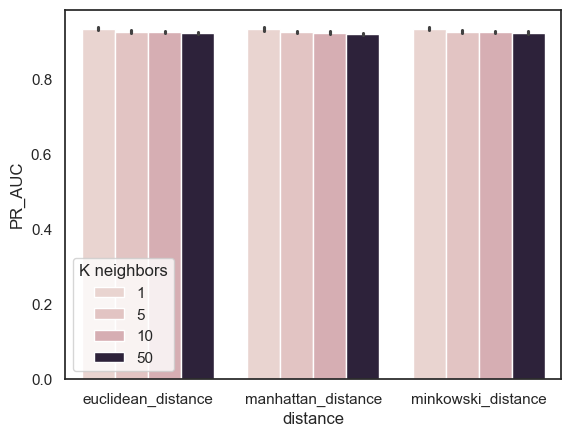

In [84]:
sns.barplot(result_df, x="distance", y="PR_AUC", hue="K neighbors")

Co ciekawe pole powierzchni pod krzywą PR spada dla coraz większej liczby sąsiadów. 

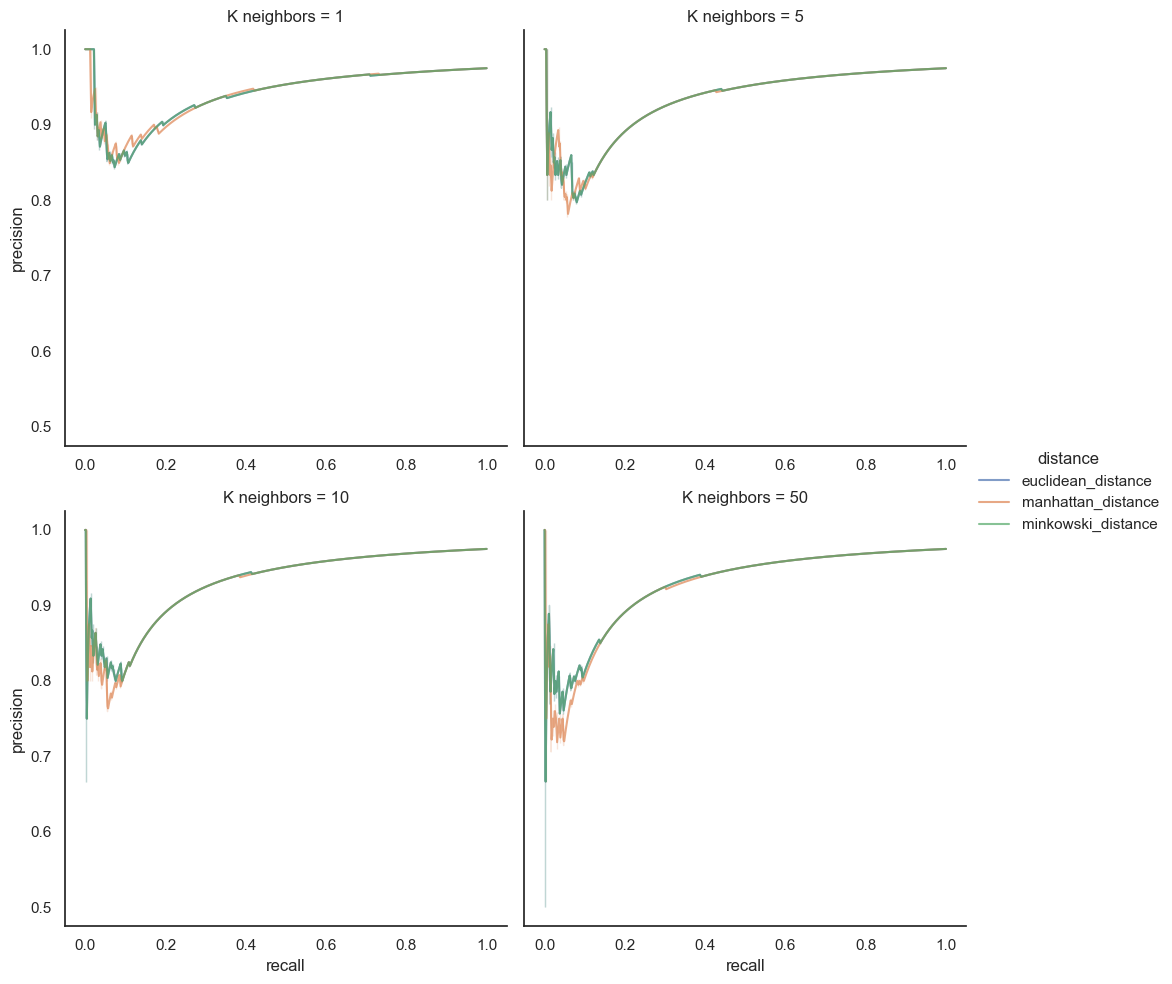

In [86]:
#plot PR curves
pr_df = result_df[result_df["CV"] == 1]
#pr_df = pr_df[pr_df["K neighbors"] == 10]

pr_df = pr_df.explode(['recall', 'precision'])

sns.relplot(
    data=pr_df,
    x="recall", y="precision",
    hue="distance", col="K neighbors",
    kind="line",
    facet_kws=dict(sharex=False),
    col_wrap=2,
    alpha=0.7
)

Krzywe PR dla różnych miar odległości są bardzo bliskie siebie, do tego stpnia że odległość euklidejska i minkowski praktycznie się na siebie nakładają. 

### Testy dla zbioru "shuttle"

In [24]:
result_df = test_functions.test_loop(shuttle_features, shuttle_labels, n_neighbors, distances, [None])

<Axes: xlabel='distance', ylabel='PR_AUC'>

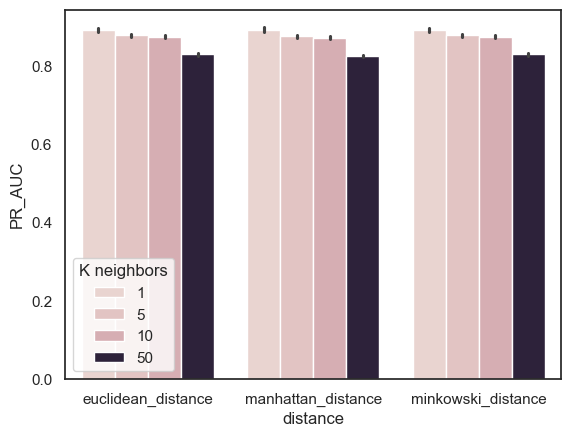

In [25]:
sns.barplot(result_df, x="distance", y="PR_AUC", hue="K neighbors")

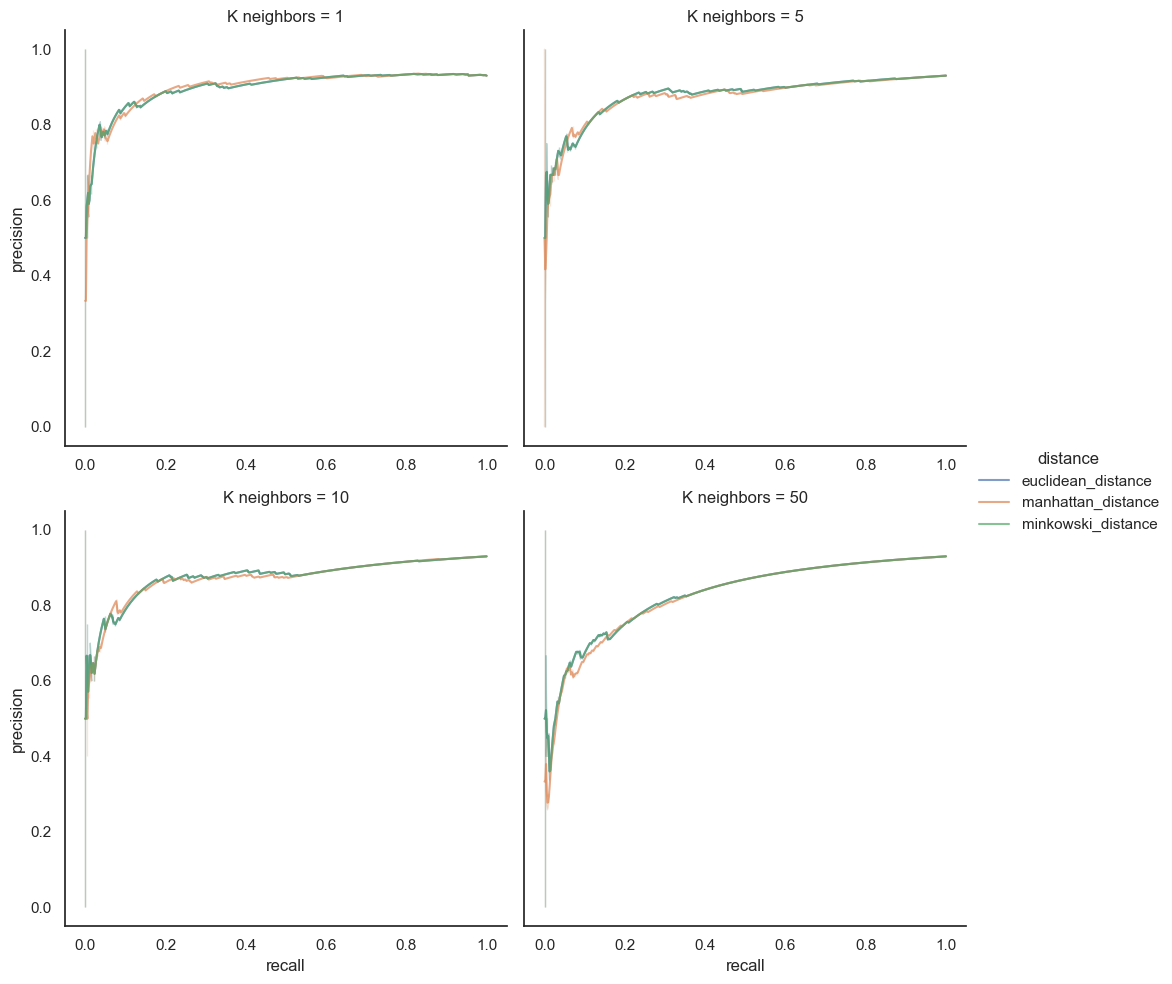

In [26]:
#plot PR curves
pr_df = result_df[result_df["CV"] == 1]
#pr_df = pr_df[pr_df["K neighbors"] == 10]

pr_df = pr_df.explode(['recall', 'precision'])

sns.relplot(
    data=pr_df,
    x="recall", y="precision",
    hue="distance", col="K neighbors",
    kind="line",
    facet_kws=dict(sharex=False),
    col_wrap=2,
    alpha=0.7
)

# Testy dla średniej odległości od k-najbliższych sąsiadów i odległości od k-tego sąsiada

In [ ]:
def distance_from_nth(X):
    # proess input data instead of train data
    X = np.array(X)
    
    distances = self.calc_distances_pred(self.X_train, X, self.distance_func)

    # default decition is based on mean distance to k nearest neighbors
    nearest_neighbors = np.argsort(distances, axis=1)[:, :self.k]
    scores = np.mean(distances[np.arange(len(X))[:, None], nearest_neighbors], axis=1)

    return scores 

@nb.jit(nopython=True)  
def distance_avg(x1, x2, p=2):
    return 

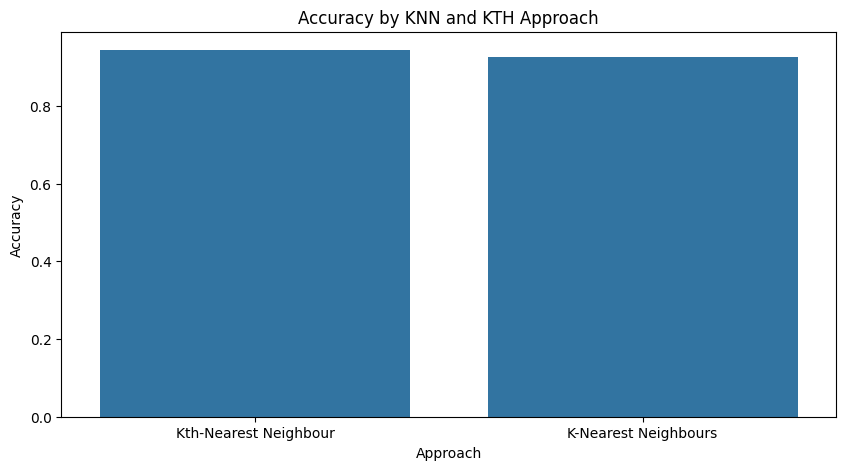

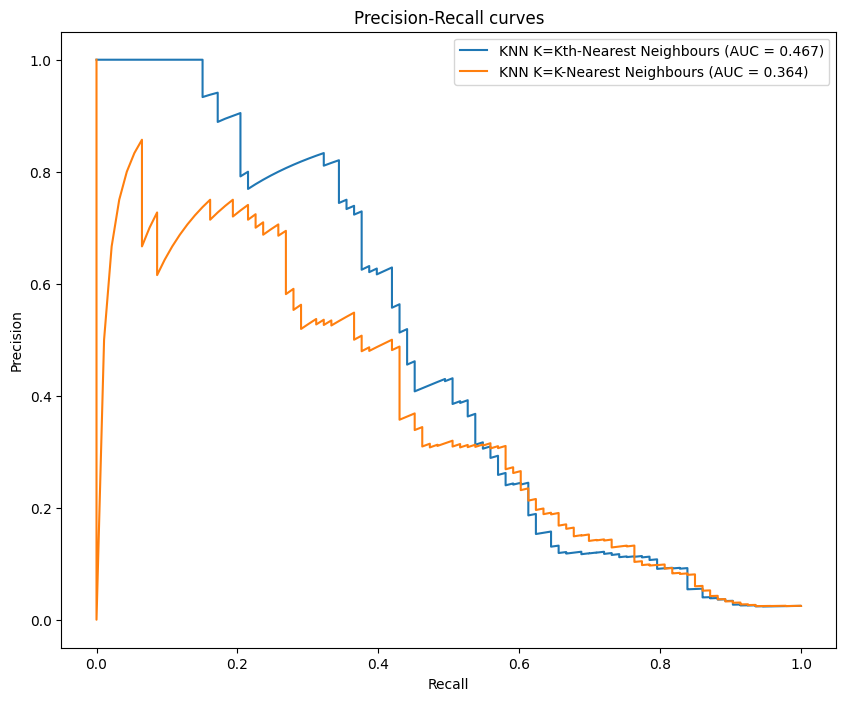

In [5]:
knn_or_kth = [0, 1]
train_for_knn_or_kth(X, y, knn_or_kth)

# Testy dla treningu bez anomalii oraz traningu z anomaliami

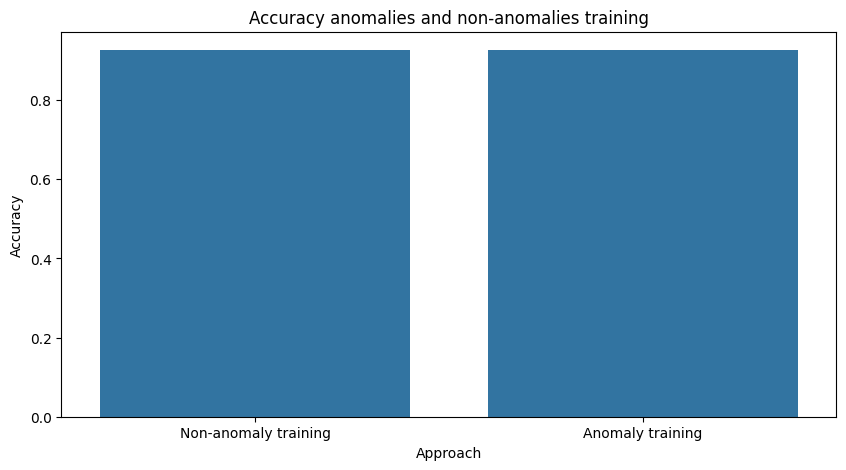

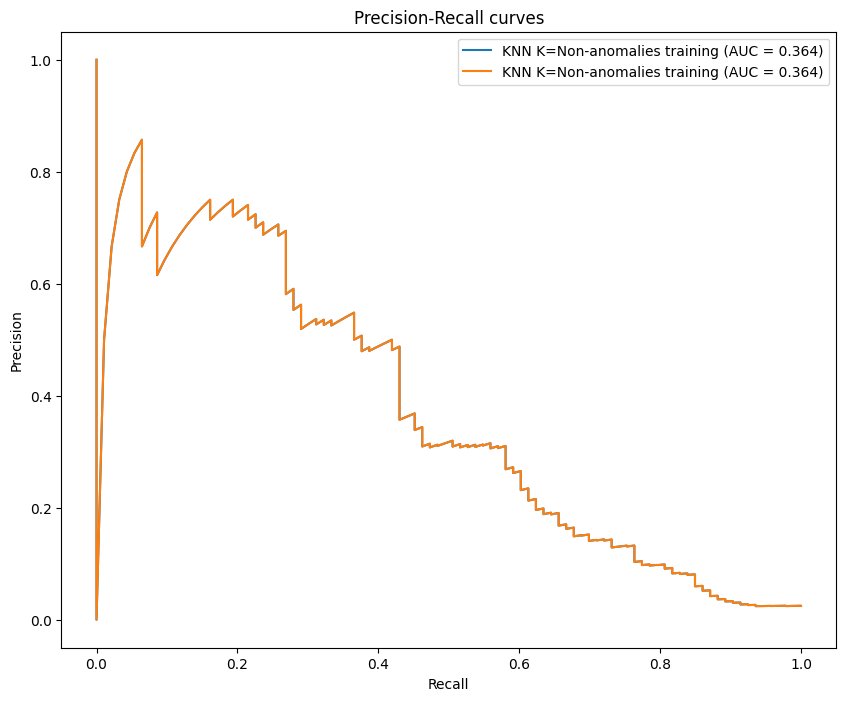

In [5]:
a_or_na = [0, 10]
train_for_anomalies_and_non_anomalies(X, y, a_or_na)